# SSD Backbone

In [1]:
import dnn; dnn.setup_gpus ()
import tensorflow as tf
from pprint import pprint as pp
from importlib import reload
from dnn import abiou
import model
import numpy as np
import label_utils
from tfserver import datasets
from dnn.architects.resnet import build_resnet
import os
import skimage
from skimage.io import imread
from skimage.util import random_noise
import service_model
from model_utils import ssd_parser
from tfserver.label import Label
import cv2
import random

parser = ssd_parser()
args = parser.parse_args()

### Build Model

In [8]:
def build_label_dictionary (path):
    # label is [frame,xmin,xmax,ymin,ymax,class_id]
    # ['0000000.jpg' '354' '431' '301' '470' '3']
    # ['0000000.jpg' '480' '581' '218' '480' '1']
    labels = label_utils.load_csv(path)
    labels = labels[1:]
    keys = np.unique(labels[:,0])
    dictionary = label_utils.get_label_dictionary(labels, keys)
    classes = np.unique(labels[:,-1]).astype(int).tolist()
    classes.insert(0, 0) # insert background label 0
    print("Num of unique classes: ", classes)
    return dictionary, classes

args.batch_size = 16
args.normalize = service_model.NORMALIZE
args.threshold = service_model.LABEL_IOU_THRESHOLD
args.iou_threshold = service_model.IOU_THRESHOLD
args.class_threshold = service_model.CLASS_THRESHOLD
args.soft_nms = service_model.SOFT_NMS

args.height,args.width, args.channels = service_model.INPUT_SHAPE
args.layers = service_model.N_LAYERS

input_shape = (args.height, args.width, args.channels)
n_layers = args.layers

service_model.LABEL = Label (["Water", "Soda", "Juice"]) # remove background
label = service_model.LABEL
n_classes = len (label)

service_model.INPUT_SHAPE = (244, 244, 3)

path = os.path.join(args.data_path, args.train_labels)
dictionary, classes = build_label_dictionary(path)
train_xs, train_ys = [], []
for k, v in dictionary.items ():
    train_xs.append (k)
    train_ys.append (v)

path = os.path.join(args.data_path, args.test_labels)
vdictionary, _ = build_label_dictionary(path)
valid_xs, valid_ys = [], []
for k, v in vdictionary.items ():
    valid_xs.append (k)
    valid_ys.append (v)    

Num of unique classes:  [0, 1, 2, 3]
Num of unique classes:  [0, 1, 2, 3]


In [3]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.layers import ELU, MaxPooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from dnn import layers

def build_ssd(input_shape, n_layers, n_classes):    
    backbone = build_resnet (input_shape, n_layers = n_layers)    
    inputs = Input(shape=input_shape)
    x = backbone(inputs) [-1]
    x = layers.global_avg_pool2d (x)
    x = layers.dropout (x, 0.3)
    x = layers.dense (x, 128, kreg = layers.l2 (0.01))
    x = layers.batch_norm_with_dropout (x, 0.3, activation = 'elu')
    x = layers.dense (x, 64, kreg = layers.l2 (0.01))
    x = layers.dense (x, n_classes, activation = 'softmax')
    _model = Model(inputs=inputs, outputs=x, name='ssd_backbone')
    return backbone, _model

backbone, model = build_ssd (service_model.INPUT_SHAPE, service_model.N_LAYERS, len (service_model.LABEL))

In [4]:
model.summary ()

Model: "ssd_backbone"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
ResNet56v2 (Functional)      [(None, 15, 15, 256), (No 2189504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
batch_normalization_55 (Batc (None, 128)               512       
_________________________________________________________________
tf.nn.elu (TFOpLambda)       (None, 128)              

### Image Preprocessing

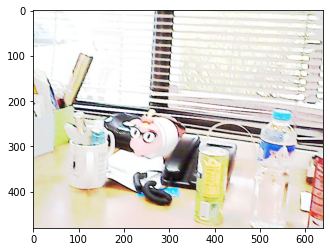

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
img = imread ('dataset/0000000.jpg')
plt.imshow (img)

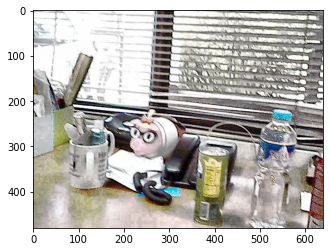

In [6]:
reload (service_model)
arr = service_model.load_image ('dataset/0000000.jpg')
plt.imshow (arr)

### Data Generator

In [12]:
reload (abiou)
reload (datasets)
# reload (service_model)

def gen (xs, ys, normalizer = None, augment = False):    
    def fixed ():
        idxes = np.random.permutation (len (ys))
        for idx in idxes:    
            key, labels = xs [idx], np.array (ys [idx])            
            image_path = os.path.join (args.data_path, key)
            image = service_model.load_image (image_path, rescale = True)
            for item in labels:
                box = item [:4].astype (np.int16)
                if augment:
                    box = abiou.stretch_box (image, box)
                label = int (item [-1]) - 1
                x = image [box [2]:box [3], box [0]:box [1]]                
                x = cv2.resize (x, (244, 244))
                y = np.zeros ([3])
                y [label] = 1.0                
                yield x, y                
    return fixed        

ds = datasets.from_generator (
    gen, label,
    train_xs, train_ys,
    vaild_xs, valid_ys,
    batch_size = 16
)

for idx, (xs, ys) in enumerate (ds.trainset.as_numpy_iterator ()):          
    print (xs.shape, ys.shape)
    break

(16, 244, 244, 3) (16, 3)


### Compile and Fit



confusion matrix of label

       Wa So Ju
    Wa 33  0  0
    So  7 55  0
    Ju  1  0 50
    metrics: lot=146, acc=0.945, f1=0.947, auc=0.965, prc=0.956, rcl=0.945
____________________________________________________________

Best epoch: 1.0000 - val_loss: 2.3640 - val_acc: 0.9452 - val_f1: 0.9467 - val_auc: 0.9646
confusion matrix of label

       Wa So Ju
    Wa 33  0  0
    So  7 55  0
    Ju  1  0 50
    metrics: lot=146, acc=0.945, f1=0.947, auc=0.965, prc=0.956, rcl=0.945
____________________________________________________________



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

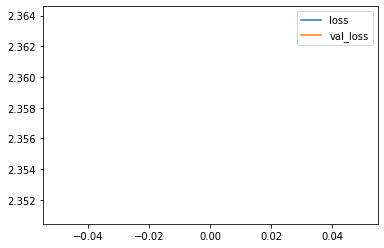

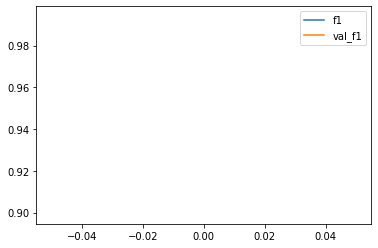

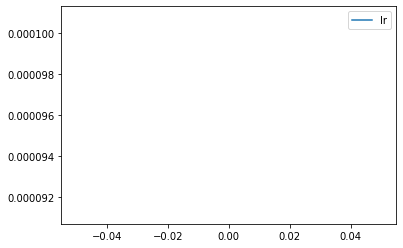

In [17]:
from dnn import callbacks
from dnn.losses.ssd import focal_loss_categorical, smooth_l1_loss, l1_loss
from tensorflow.keras.optimizers import Adam

%matplotlib inline
model.compile (optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

reload (callbacks)
history = model.fit (
    ds.trainset,
    validation_data = ds.validset,
    epochs = 6,
    steps_per_epoch = int (len (train_ys) * 2) // 16,
    callbacks = callbacks.conventional (
        os.path.join(os.getcwd(), 'temp', 'backbone'),
        ds, (1e-4, 0.96), 20, 'val_loss', ['loss', 'f1'],
        reset_train_dir = True
    )
)

In [15]:
model.evaluate (ds.validset)

10/10 [==============================] - 10s 956ms/step - loss: 2.4843 - acc: 1.0000


[2.484309434890747, 1.0]

### Saving Backbone Weights

In [16]:
backbone.save ('weights/backbone.h5')